## Determinism

In [1]:
from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")

Training results should now be reproducible.


## Order of classes
It is *not* the case that the first 25 classes are cats and the last 12 are dog. See the following example

(0, 0)
Abyssinian
Cat


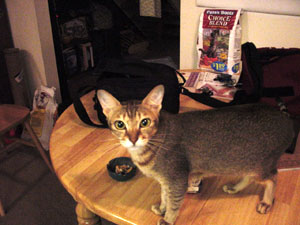

(1, 1)
American Bulldog
Dog


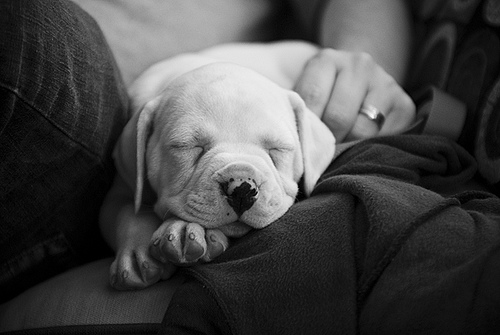

(2, 1)
American Pit Bull Terrier
Dog


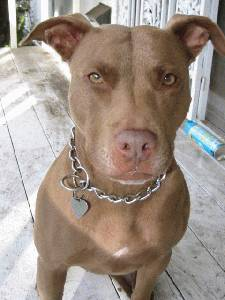

In [2]:
from datasets import load_dataset
dataset = load_dataset("test", None, target_types=("category", "binary-category"))
idx_to_class = {i : c for i, c in enumerate(dataset.classes)}
idx_to_bin_class = {i : c for i, c in enumerate(dataset.bin_classes)}
for i in [0, 100, 200]:
    print(dataset[i][1]) # (0,0) 
    print(idx_to_class[dataset[i][1][0]])
    print(idx_to_bin_class[dataset[i][1][1]])
    display(dataset[i][0])
    
# Determine 
#breed_family_idx = sorted(set([pair[1] for pair in dataset]))

## Train model on imbalanced dataset with Standard Cross-Entropy

We train a model using parameters from previous exercise (TODO) on a dataset where we retain only 20% of training images for each cat breed. We expect it to be biased toward dog breeds or majority classes due to the class imbalance. We observe that the validation accuracy is lower (about 10% lower than normal).

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.001,
    "weight_decay": 0,
    "name": "adam"
  },
  "n_epochs": 3,
  "freeze_layers": true,
  "validation_freq": 1,
  "augmentation": {
    "enabled": false
  },
  "fixmatch": false,
  "unsup_weight": 0.5,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}


Update step:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch [1/3], Loss: 2.1438, Train Acc: 61.53%, Val Acc: 82.50%
Epoch [2/3], Loss: 0.7898, Train Acc: 91.87%, Val Acc: 84.90%
Epoch [3/3], Loss: 0.4462, Train Acc: 94.43%, Val Acc: 85.45%
Total elapsed: 27.43s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/6595fd44248db0aaaae9caaad3b3c32a.pth
Training result:
{
  "training_losses": [2.1438355296850204, 0.7897826926782727, 0.44618242932483554],
  "training_accuracies": [0.6152709359605911, 0.9187192118226601, 0.9443349753694581],
  "validation_accuracies": [0.8250460405156538, 0.848987108655617, 0.85451197053407],
  "update_steps": [64, 128, 192],
  "epochs": [1, 2, 3],
  "training_elapsed": 27.430431264000163
}


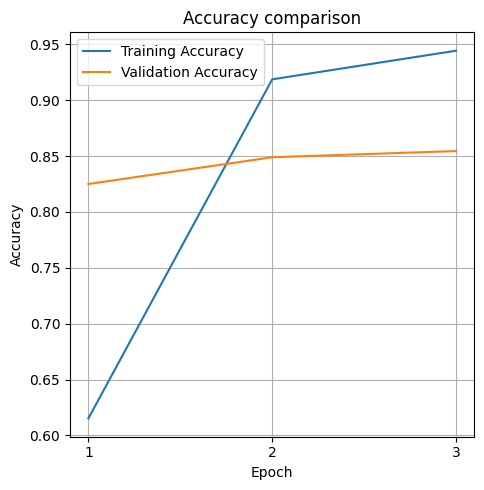

In [3]:
from typing import Literal
import augmentation
from augmentation import AugmentationParams

%reload_ext autoreload
%autoreload 2

from training import TrainParams, AdamParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds
from run import run, make_trained_trainer
from caching import invalidate_cache_entry
from datasets import DatasetParams

# Map from breed index to family index (ex. Abbyssinian (0) to Cat (0))
# Hardcoded, but can be computed like this
#breed_family_idx = [y for _,y in sorted(set([pair[1] for pair in dataset]))]
breed_family_idx = [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
                    1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    # Reduce cat data by 80 %
    # 0 = cat, 1 = dog
    class_fractions = tuple(0.2 if x == 0 else 1.0 for x in breed_family_idx),
    validation_set_fraction=0.2,  # Use 20% of trainval set for validation
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=3,
    optimizer=AdamParams(
        learning_rate=1e-3,
        weight_decay=0,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    augmentation=AugmentationParams(
        enabled=False,
        transform=None,
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

run_args = (dataset_params, baseline_params, determinism)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

## Test imbalanced model

What happens to the final test performance on the classes with limited training data? We observe a much lower test accuracy on these underrepresented classes. Importantly, the performance drops more than expected. The decrease in accuracy is not proportional to the reduction in training data.

In [4]:
from run import try_loading_trainer
from evaluation import evaluate_predictions, evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning
from tqdm import tqdm

suppress_weights_only_warning()

trainer = try_loading_trainer(dataset_params, baseline_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(baseline_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)

print(f"Test size: {len(test_loader.dataset)}")

predicted, truth, _ = evaluate_predictions(trainer, test_loader, test_dataset)

test_acc = 100 * sum(x == y for x, y in zip(predicted, truth)) / len(predicted)
cats = [x == y for x, y in zip(predicted, truth) if breed_family_idx[y] == 0]
dogs = [x == y for x, y in zip(predicted, truth) if breed_family_idx[y] == 1]
cat_test_acc = 100 * sum(cats) / len(cats)
dog_test_acc = 100 * sum(dogs) / len(dogs)
print(f"Final test accuracy: {test_acc:.2f} %")
print(f"Final test accuracy for cats: {cat_test_acc:.2f} %")
print(f"Final test accuracy for dogs: {dog_test_acc:.2f} %")

families = list("Cat" if x == 0 else "Dog" for x in breed_family_idx)
breed_fam_names = [f"{name} ({fam})" for name, fam in zip(dataset.classes,families)]

Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/6595fd44248db0aaaae9caaad3b3c32a.pth (epoch 3)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final test accuracy: 64.92 %
Final test accuracy for cats: 6.34 %
Final test accuracy for dogs: 92.80 %


## Distribution of labels

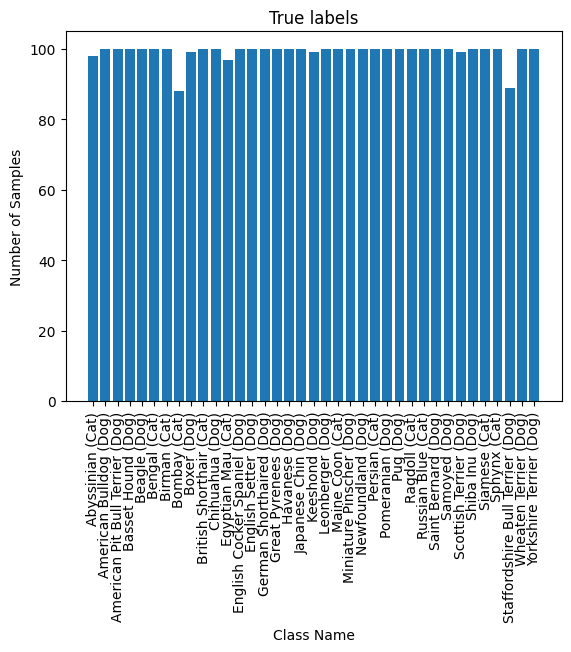

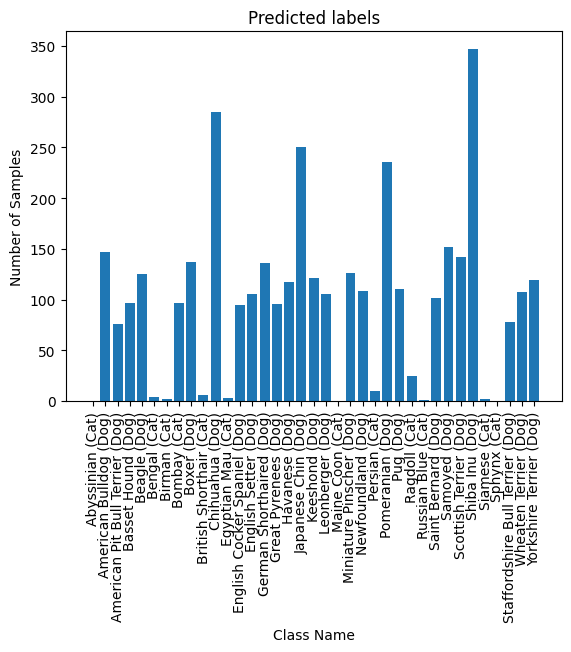

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter
plt.bar(breed_fam_names, Counter(truth).values())
plt.xlabel("Class Name")
plt.ylabel("Number of Samples")
plt.title("True labels")
plt.xticks(rotation=90)
plt.show()

plt.bar(breed_fam_names, [Counter(predicted).get(i, 0) for i in range(len(breed_fam_names))])
plt.xlabel("Class Name")
plt.ylabel("Number of Samples")
plt.title("Predicted labels")
plt.xticks(rotation=90)
plt.show()

## Classification report
Precision (correctness) is defined as tp/(tp+fp). If the model never predicts the class at all, both tp and fp will be zero, so we will have division by zero. In that case precision is set to zero. This is the case with Abyssinian. For Bengal, we have 4 tp but no fp. Hence precision will be 1. This makes sense because the dataset is biased towards dogs so it is unlikely that a dog will be missclassified as a cat.

Recall (completeness, sensitivity) is defined as tp/(tp+fn). Most cats have many false negatives (i.e. predicted as dogs), so recall will be low for most cats. The exception is Bombay cats, which the model handles a bit better. Bombay cats are completely black, except for their eyes. Perhaps something about their distinct look make them easier to classify?


In [6]:
from sklearn.metrics import classification_report
print(classification_report(truth, predicted, 
                            target_names=breed_fam_names,
                            zero_division=0))

                                  precision    recall  f1-score   support

                Abyssinian (Cat)       0.00      0.00      0.00        98
          American Bulldog (Dog)       0.56      0.82      0.66       100
 American Pit Bull Terrier (Dog)       0.72      0.55      0.62       100
              Basset Hound (Dog)       0.96      0.93      0.94       100
                    Beagle (Dog)       0.78      0.97      0.86       100
                    Bengal (Cat)       1.00      0.04      0.08       100
                    Birman (Cat)       1.00      0.02      0.04       100
                    Bombay (Cat)       0.44      0.49      0.46        88
                     Boxer (Dog)       0.67      0.93      0.78        99
         British Shorthair (Cat)       0.83      0.05      0.09       100
                 Chihuahua (Dog)       0.31      0.88      0.46       100
              Egyptian Mau (Cat)       1.00      0.03      0.06        97
    English Cocker Spaniel (Dog)     

## Confusion matrix
The numbers in the confusion matrix are absolute numbers, not percentages. Diagonal values (top-left to bottom-right) are correct predictions while off-diagonal values are misclassifications. For example, we see that none of the Abyssinian samples where correctly predicted, and 38 where incorrectly predicted as Chihuahuas and 38 as Shibas, two dog breeds that apparently cats are easily confused with.

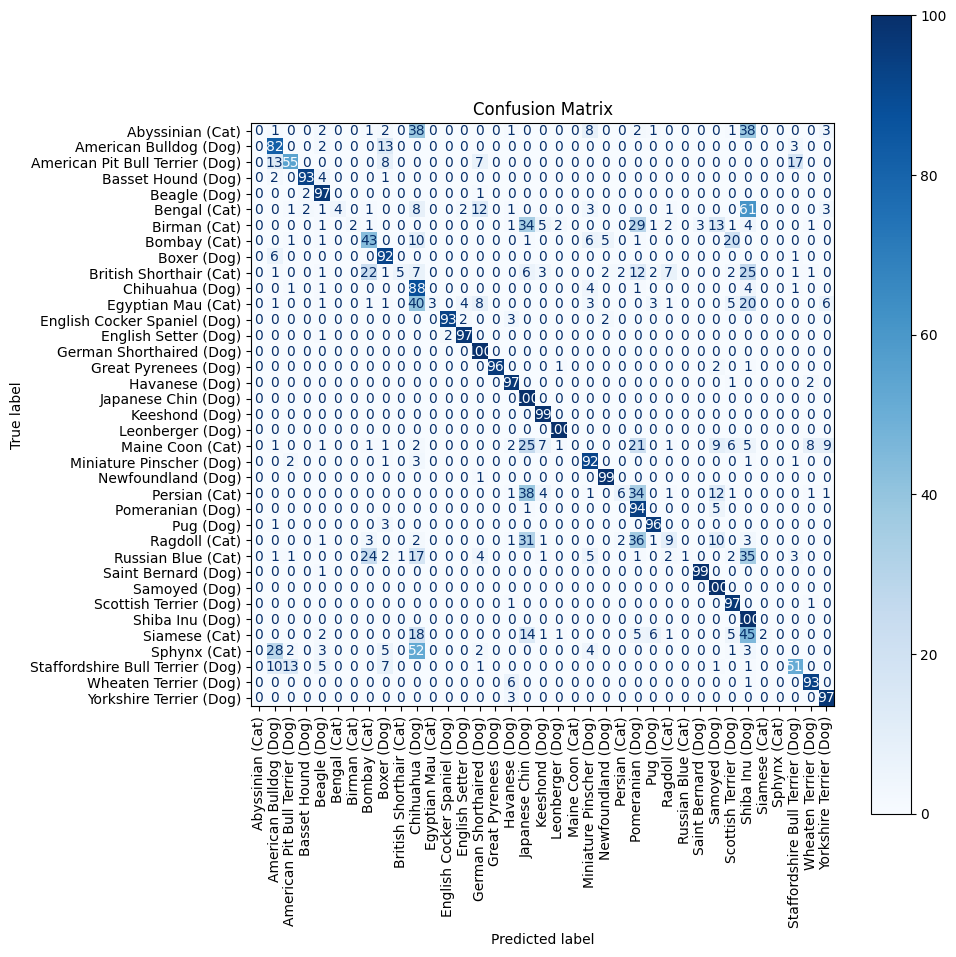

In [7]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(truth, predicted, labels=[i for i in range(37)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breed_fam_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Compensate using weighted cross-entropy
Now we try to compensate for the inbalance by adding weights. We train again using the new `class_weights` parameter. We see that adding weights improve the result. Interestingly just setting `class_weights` to `1/class_fractions` is not enough to compensate when the imbalance is large. The more we increase the weights for the cat classes, the better test accuracy we get for cats. If the weights get too large, the dog test accuracy will start to decrease.

```
cat_vs_dog_ratio = 5:
Final test accuracy: 74.46 %
Final test accuracy for cats: 36.09 %
Final test accuracy for dogs: 92.72 %

10:
Final test accuracy: 76.48 %
Final test accuracy for cats: 42.60 %
Final test accuracy for dogs: 92.60 %

20:
Final test accuracy: 77.73 %
Final test accuracy for cats: 46.75 %
Final test accuracy for dogs: 92.48 %


50:
Final test accuracy: 78.11 %
Final test accuracy for cats: 47.93 %
Final test accuracy for dogs: 92.48 %

100:
Final test accuracy: 78.11 %
Final test accuracy for cats: 48.44 %
Final test accuracy for dogs: 92.24 %
```

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.001,
    "weight_decay": 0,
    "name": "adam"
  },
  "n_epochs": 3,
  "freeze_layers": true,
  "validation_freq": 1,
  "augmentation": {
    "enabled": false
  },
  "fixmatch": false,
  "unsup_weight": 0.5,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1,
  "class_weights": [20, 1.0, 1.0, 1.0, 1.0, 20, 20, 20, 1.0, 20, 1.0, 20, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 20, 1.0, 1.0, 20, 1.0, 1.0, 20, 20, 1.0, 1.0, 1.0, 1.0, 20, 20, 1.0, 1.0, 1.0]
}
Training result:
{
  "training_losses": [2.624408684670925, 0.9998959610238671, 0.497266826685518],
  "training_accuracies": [0.6162561576354679, 0.9305418719211823, 0.9541871921182266],
  "validation_accuracies": [0.8379373848987108, 0.8931860036832413, 0.8950276243093923],
  "update_steps": [64, 128, 192],
  "epochs": [1, 2, 3],
  "training_elapsed": 26.64075577499989
}


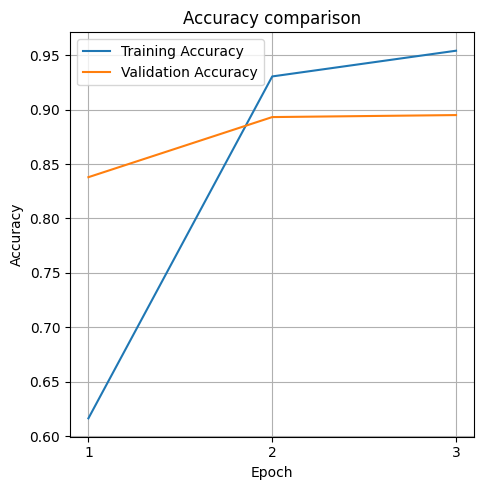

In [40]:
from typing import Literal
import augmentation
from augmentation import AugmentationParams

%reload_ext autoreload
%autoreload 2

from training import TrainParams, AdamParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds
from run import run, make_trained_trainer
from caching import invalidate_cache_entry
from datasets import DatasetParams

# Map from breed index to family index (ex. Abbyssinian (0) to Cat (0))
# Hardcoded, but can be computed like this
#breed_family_idx = [y for _,y in sorted(set([pair[1] for pair in dataset]))]
breed_family_idx = [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
                    1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    # Reduce cat data by 80 %
    # 0 = cat, 1 = dog
    class_fractions = tuple(0.2 if x == 0 else 1.0 for x in breed_family_idx),
    validation_set_fraction=0.2,  # Use 20% of trainval set for validation
)

cat_vs_dog_ratio = 20

class_weights = tuple(
    cat_vs_dog_ratio if fam_idx == 0 else 1.0
    for fam_idx in breed_family_idx
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=3,
    optimizer=AdamParams(
        learning_rate=1e-3,
        weight_decay=0,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    augmentation=AugmentationParams(
        enabled=False,
        transform=None,
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
    class_weights = class_weights
)

run_args = (dataset_params, baseline_params, determinism)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

## Evaluate again
We check the result.

In [41]:
from run import try_loading_trainer
from evaluation import evaluate_predictions, evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning
from tqdm import tqdm

suppress_weights_only_warning()

trainer = try_loading_trainer(dataset_params, baseline_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(baseline_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)

print(f"Test size: {len(test_loader.dataset)}")

predicted, truth, _ = evaluate_predictions(trainer, test_loader, test_dataset)

test_acc = 100 * sum(x == y for x, y in zip(predicted, truth)) / len(predicted)
cats = [x == y for x, y in zip(predicted, truth) if breed_family_idx[y] == 0]
dogs = [x == y for x, y in zip(predicted, truth) if breed_family_idx[y] == 1]
cat_test_acc = 100 * sum(cats) / len(cats)
dog_test_acc = 100 * sum(dogs) / len(dogs)
print(f"Final test accuracy: {test_acc:.2f} %")
print(f"Final test accuracy for cats: {cat_test_acc:.2f} %")
print(f"Final test accuracy for dogs: {dog_test_acc:.2f} %")

families = list("Cat" if x == 0 else "Dog" for x in breed_family_idx)
breed_fam_names = [f"{name} ({fam})" for name, fam in zip(dataset.classes,families)]

Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/128208dc00c7c9a20a18d09ad9e3320a.pth (epoch 3)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final test accuracy: 77.73 %
Final test accuracy for cats: 46.75 %
Final test accuracy for dogs: 92.48 %


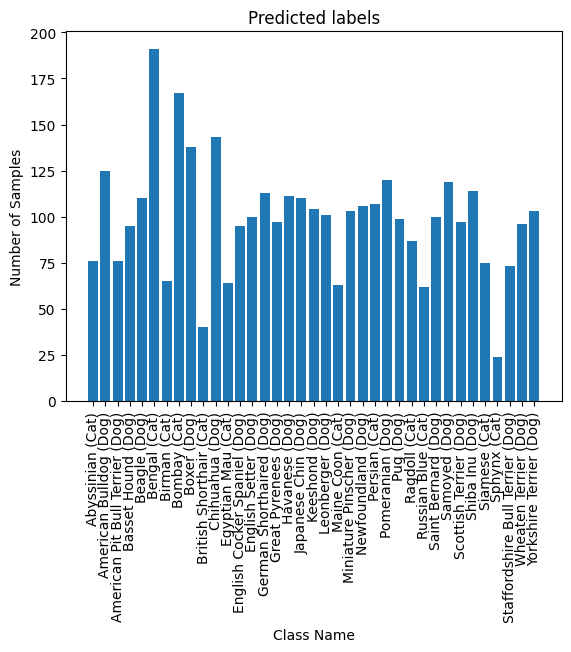

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(breed_fam_names, [Counter(predicted).get(i, 0) for i in range(len(breed_fam_names))])
plt.xlabel("Class Name")
plt.ylabel("Number of Samples")
plt.title("Predicted labels")
plt.xticks(rotation=90)
plt.show()

In [43]:
from sklearn.metrics import classification_report
print(classification_report(truth, predicted, 
                            target_names=breed_fam_names,
                            zero_division=0))

                                  precision    recall  f1-score   support

                Abyssinian (Cat)       0.47      0.37      0.41        98
          American Bulldog (Dog)       0.63      0.79      0.70       100
 American Pit Bull Terrier (Dog)       0.72      0.55      0.62       100
              Basset Hound (Dog)       0.98      0.93      0.95       100
                    Beagle (Dog)       0.88      0.97      0.92       100
                    Bengal (Cat)       0.40      0.76      0.52       100
                    Birman (Cat)       0.65      0.42      0.51       100
                    Bombay (Cat)       0.46      0.88      0.60        88
                     Boxer (Dog)       0.67      0.93      0.78        99
         British Shorthair (Cat)       0.80      0.32      0.46       100
                 Chihuahua (Dog)       0.62      0.88      0.72       100
              Egyptian Mau (Cat)       0.70      0.46      0.56        97
    English Cocker Spaniel (Dog)     

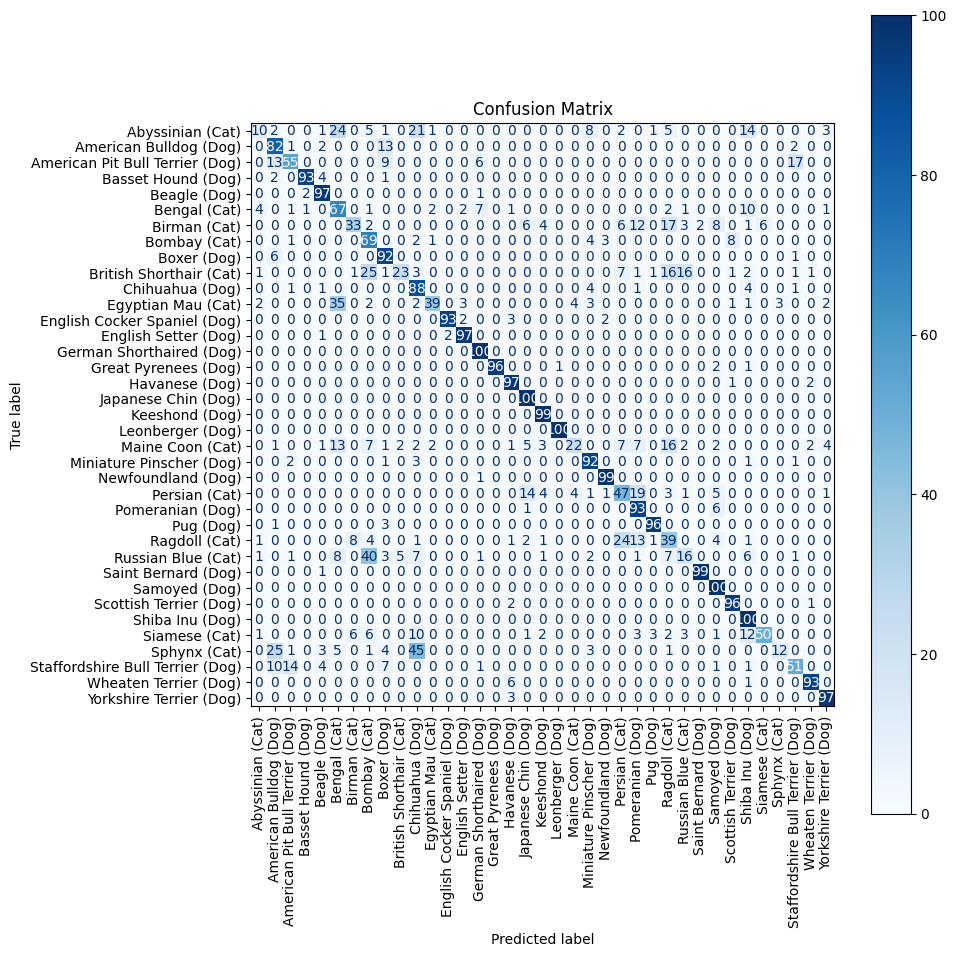

In [12]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(truth, predicted, labels=[i for i in range(37)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breed_fam_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()